# Семинар 8: Оценка качества моделей, кросс-валидация, подбор гиперпараметров

<a href="https://colab.research.google.com/github/SergeyMalashenko/MachineLearning_Summer_2023/blob/main/seminars/9/seminar_9.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

На предыдущем семинаре мы рассмотрели основной алгоритм применения модели машинного обучения:

1. Выбор класса модели.
2. Выбор гиперпараметров модели.
3. Подгонка модели к обучающим данным.
4. Использование модели для предсказания меток для новых данных.

Первые две части - выбор модели и выбор гиперпараметров - являются, пожалуй, самой важной частью эффективного использования этих инструментов и методов.
Чтобы сделать обоснованный выбор, нам нужен способ *подтвердить*, что наша модель и наши гиперпараметры хорошо подходят к данным.

### Оценка качества моделей: неправильный подход

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Выбираем модель и гиперпараметры. Здесь мы будем использовать *KNeighborsClassifier* с ``n_neighbors=1``.
Это очень простая и интуитивно понятная модель, которая говорит, что "метка неизвестной точки совпадает с меткой ее ближайшей обучающей точки:".

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [3]:
model.fit(X, y)
y_model = model.predict(X)

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

Мы видим оценку точности 1,0, что означает, что 100% точек были правильно помечены нашей моделью!
Но действительно ли это измерение ожидаемой точности? 
Действительно ли мы нашли модель, которая, как мы ожидаем, будет правильной в 100% случаев?

Как вы уже догадались, ответ отрицательный.
На самом деле, этот подход содержит фундаментальный недостаток: *он обучает и оценивает модель на одних и тех же данных*.
Более того, модель ближайшего соседа - это *оценка на основе случая*, которая просто хранит обучающие данные и предсказывает метки, сравнивая новые данные с этими сохраненными точками: за исключением надуманных случаев, она будет давать 100% точность *каждый раз*.

### Оценка качества моделей: валидация на отложенной выборке

Лучшее представление о производительности модели можно получить, используя так называемый *холд-аут набор*: то есть, мы удерживаем некоторое подмножество данных от обучения модели, а затем используем этот холд-аут набор для проверки производительности модели.
Такое разбиение можно сделать с помощью утилиты ``train_test_split`` в Scikit-Learn:

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

### Оценка качества моделей: перекрестная валидация

Одним из недостатков использования набора данных для проверки модели является то, что мы потеряли часть данных для обучения модели.
В приведенном выше случае половина набора данных не участвует в обучении модели!
Это не оптимально и может вызвать проблемы - особенно если начальный набор обучающих данных невелик.

Одним из способов решения этой проблемы является использование *перекрестной валидации*; то есть, проведение последовательности подгонок, в которых каждое подмножество данных используется и как обучающий набор, и как проверочный набор.
Визуально это может выглядеть примерно так:

![](images/05.03-2-fold-CV.png)

Здесь мы проводим два проверочных испытания, поочередно используя каждую половину данных в качестве промежуточного набора.
Используя разделенные данные, мы могли бы реализовать это следующим образом:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

В результате получаются две оценки точности, которые мы можем объединить (например, взяв среднее значение), чтобы получить более точную оценку эффективности глобальной модели.
Эта конкретная форма кросс-валидации является *двухкратной кросс-валидацией*, то есть, когда мы разделили данные на два набора и использовали каждый из них по очереди в качестве проверочного набора.

Мы можем расширить эту идею, чтобы использовать еще больше испытаний и больше складок в данных - например, вот визуальное изображение пятикратной кросс-валидации:

![](images/05.03-5-fold-CV.png)

Здесь мы разбиваем данные на пять групп и используем каждую из них по очереди для оценки соответствия модели на остальных 4/5 данных.
Это было бы довольно утомительно делать вручную, поэтому мы можем использовать удобную процедуру Scikit-Learn ``cross_val_score'', чтобы сделать это лаконично:

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
scores.mean()

0.96

### Выбор лучшей модели

Теперь, когда мы рассмотрели основы валидации и перекрестной валидации, мы немного углубимся в выбор модели и подбор гиперпараметров.
Эти вопросы являются одними из самых важных аспектов практики машинного обучения, и в вводных учебниках по машинному обучению эта информация часто упускается.

Основное значение имеет следующий вопрос: *если наша оценка не оправдывает себя, как мы должны двигаться дальше?
Есть несколько возможных ответов:

- Использовать более сложную/более гибкую модель
- Использовать менее сложную/менее гибкую модель
- Собрать больше обучающих выборок
- Собрать больше данных, чтобы добавить признаки к каждому примеру.

Ответ на этот вопрос часто бывает контринтуитивным.
В частности, иногда использование более сложной модели дает худшие результаты, а добавление большего количества обучающих выборок может не улучшить ваши результаты.
Способность определить, какие шаги улучшат вашу модель - это то, что отделяет успешных практиков машинного обучения от неуспешных.

### The Bias-variance trade-off. Дилемма смещения и дисперсии

По сути, вопрос о "лучшей модели" заключается в поиске оптимального соотношения между *смещением (bias)* и *дисперсией (variance)*.
Рассмотрим следующий рисунок, на котором представлены две регрессионные модели для одного и того же набора данных:

![](images/05.03-bias-variance.png)


Очевидно, что ни одна из этих моделей не описывают данные достаточно хорошо.

Модель слева пытается найти прямую линию, проходящую через данные.
Поскольку данные по своей сути сложнее прямой линии, линейная модель никогда не сможет хорошо описать этот набор данных.
О такой модели говорят, что она *не подходит* к данным: то есть, она не обладает достаточной гибкостью модели, чтобы учесть все особенности данных; другой способ сказать это - что модель имеет высокое *смещение (bias)*.

Модель справа пытается подобрать к данным полином высокого порядка.
Здесь модель обладает достаточной гибкостью, чтобы почти идеально учесть все тонкие особенности данных, но, несмотря на то, что она очень точно описывает обучающие данные, ее точная форма, похоже, больше отражает конкретные шумовые свойства данных, чем внутренние свойства того процесса, который породил эти данные.
О такой модели говорят, что она *оверфит* данные: то есть, она обладает настолько большой гибкостью модели, что в итоге учитывает случайные ошибки так же, как и основное распределение данных; другой способ сказать это - что модель обладает высокой *дисперсией (variance)*.

Взглянем на проблему с другой стороны, рассмотрим, что произойдет, если мы используем эти две модели для предсказания значения для некоторых новых данных.
На следующих диаграммах красные/светлые точки обозначают данные, которые были исключены из обучающего набора.

![](images/05.03-bias-variance-2.png)

Здесь используется показатель $R^2$, или [коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8), который измеряет, насколько хорошо модель работает относительно простого среднего значения целевых значений. $R^2=1$ означает идеальное соответствие, $R^2=0$ означает, что модель работает не лучше, чем простое среднее значение данных, а отрицательные значения означают еще худшие модели.
Из оценок, связанных с этими двумя моделями, мы можем сделать наблюдение, которое справедливо и для более общих случаев:

- Для моделей с высоким смещением  (bias) производительность модели на отложенной выборке аналогична производительности на обучающей выборке.
- Для моделей с высокой дисперсией (variance) производительность модели на проверочном множестве намного хуже, чем на обучающем множестве.

Если мы представим, что у нас есть возможность настраивать сложность модели, мы ожидаем, что результат на обучающей выборке и результат на отложенной выборке будут вести себя так, как показано на следующем рисунке:

![](images/05.03-validation-curve.png)

Диаграмму, показанную здесь, часто называют *валидационной кривой*, и мы видим следующие основные характеристики:

- Оценка обучения везде выше, чем оценка проверки. Обычно это так: модель лучше подходит к данным, которые она видела, чем к данным, которые она не видела.
- При очень низкой сложности модели (модель с высокой погрешностью), обучающие данные недостаточно хорошо подогнаны, что означает, что модель плохо предсказывает как обучающие данные, так и все ранее не виденные данные.
- При очень высокой сложности модели (модель с высокой дисперсией) обучающие данные слишком хорошо подогнаны, что означает, что модель очень хорошо предсказывает обучающие данные, но не подходит для любых ранее невидимых данных.
- При некотором промежуточном значении кривая валидации имеет максимум. Этот уровень сложности указывает на подходящий компромисс между смещением и дисперсией.

Способы настройки сложности модели варьируются от модели к модели; когда мы будем подробно обсуждать отдельные модели в последующих разделах, мы увидим, как каждая модель позволяет такую настройку.

### Кривые валидации в Scikit-Learn

Рассмотрим пример использования перекрестной проверки для вычисления валидационной кривой для класса моделей.
Здесь мы будем использовать модель *полиномиальной регрессии*: это обобщенная линейная модель, в которой степень полинома является настраиваемым параметром.
Например, полином степени 1 соответствует прямой линии; для параметров модели $a$ и $b$:

$$
y = ax + b
$$

Полином степени 3 соответствует кубической кривой; для параметров модели $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

Мы можем обобщить это на любое количество полиномиальных характеристик.
В Scikit-Learn мы можем реализовать это с помощью простой линейной регрессии в сочетании с полиномиальным препроцессором.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

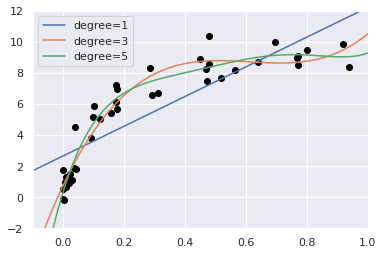

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

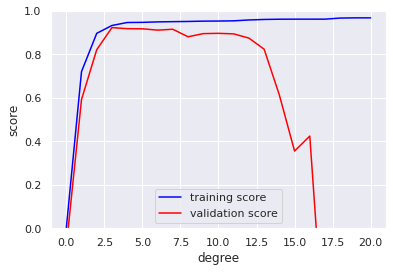

In [30]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score_1, val_score_1 = validation_curve(PolynomialRegression(), X, y, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score_1, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score_1, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

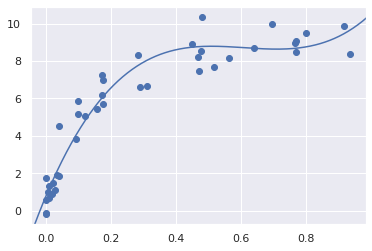

In [31]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## Кривые обучения

Одним из важных аспектов сложности модели является то, что оптимальная модель, как правило, зависит от размера ваших обучающих данных.
Cоздадим новый набор данных, содержащий в пять раз больше точек.

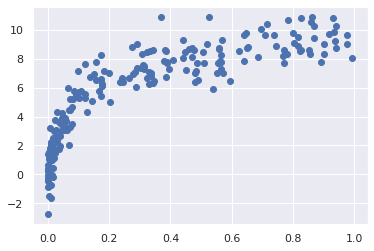

In [32]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

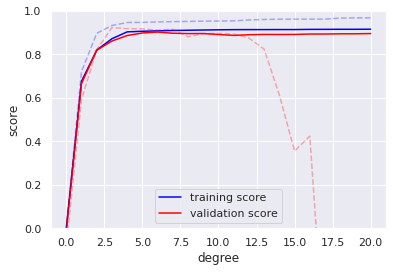

In [33]:
degree = np.arange(21)
train_score_2, val_score_2 = validation_curve(PolynomialRegression(), X2, y2, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score_2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score_2  , 1), color='red' , label='validation score')
plt.plot(degree, np.median(train_score_1, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score_1  , 1), color='red' , alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

### Кривые обучения в Scikit-Learn

Scikit-Learn предлагает удобную возможность вычисления кривых обучения. Мы вычислим кривую обучения для нашего исходного набора данных с полиномиальной моделью второго порядка и моделью девятого порядка.

![](images/05.03-learning-curve.png)

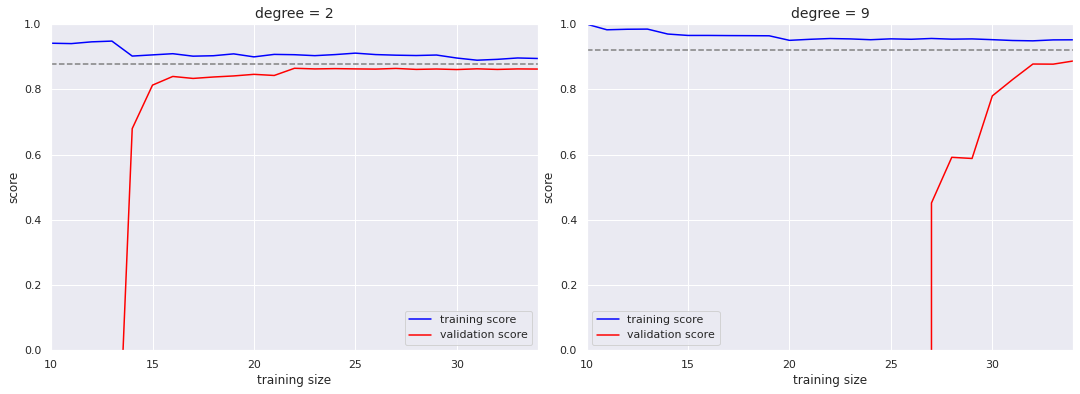

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree), X, y, cv=7, train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## Валидация на практике: поиск по сетке значений гиперпараметров

Предыдущий материал дает вам некоторое представление о дилемме между смещением и дисперсией, зависимости от сложности модели и размера обучающего набора.
На практике модели, как правило, имеют более одной одного гиперпараметра, поэтому графики кривых валидации и обучения превращаются из линий в многомерные поверхности.
В таких случаях подобная визуализация затруднительна, и мы желаем найти конкретную модель, которая максимизирует результат проверки.

Scikit-Learn предоставляет автоматические инструменты для этого.

Пример использования поиска по сетке для нахождения оптимальной полиномиальной модели посредством ``GridSearchCV``:

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__positive': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [35]:
grid.fit(X, y);

In [36]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__positive': False,
 'polynomialfeatures__degree': 4}

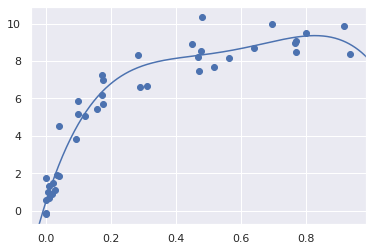

In [37]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
#plt.plot(X_test.ravel(), y_test, hold=True);
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);